# Take vsearch sintax output and plot taxonomic assignment confidence levels

### SSU rRNA reads were generated from (a) PhyloFlash on unassembled Illumina reads, (b) Illumina-SPAdes, (c) PacBio-metaFlye, and (d) Illumina-PacBio-hybridSPAdes contigs run against HMMs in anvi'o. 

### Extracted 16S rRNA reads were run against a sintax-formatted SILVA 138.1 database using vsearch v2.21.1_linux_x86_64 with the following command: 
vsearch --sintax {assembly}-16S-hmm-hits.fa --db SILVA138_RESCRIPt.fasta.gz --tabbedout {sample}-16S-sintax.out.tsv

### Extracted 18S rRNA reads were run against a sintax-formatted PR2 database using vsearch v2.21.1_linux_x86_64 with the following command:

vsearch --sintax {assembly}-18S-hmm-hits.fa --db /work/hpc/users/nvp29/databases/PR2/pr2_version_4.14.0_SSU_UTAX.fasta --tabbedout ../18S-PR2-vsearch-out/$n'_hybrid-18S-sintax-PR2-out.tsv

### For each assembly and SSU rRNA gene extraction, the 16S (SILVA) and 18S (PR2) files were concatenated for use in this script

In [113]:
import pandas as pd
import os as os
import glob as glob
import numpy as np
import re as re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
os.chdir("/Users/nastassia.patin/Desktop/Projects/Lasker2019/Long read paper/mSystems/Revisions/new-vsearch/16S-18S-concat")

### Open example file

In [3]:
vs = pd.read_csv("1903c111_10m-1_Ill-PF_16S-18S-vsearch-out-concat.tsv", sep=" |\t", header=None, names=['query', 'hit','strand'],
                engine='python')
vs.head()

,query,hit,strand
0,1903c111_10m-1_bmtag.PFspades_16_7.234130,"d:Archaea(1.00),p:Thermoplasmatota(1.00),c:The...",+
1,1903c111_10m-1_bmtag.PFspades_7_7.005598,"d:Eukaryota(1.00),p:Arthropoda(1.00),c:Maxillo...",+
2,1903c111_10m-1_bmtag.PFspades_8_3.790864,"d:Bacteria(1.00),p:Cyanobacteria(1.00),c:Cyano...",+
3,1903c111_10m-1_bmtag.PFspades_10_8.230940,"d:Eukaryota(1.00),p:Arthropoda(1.00),c:Maxillo...",+
4,1903c111_10m-1_bmtag.PFspades_9_5.962583,"d:Eukaryota(1.00),p:Prymnesiophyceae(1.00),c:P...",+


In [4]:
taxa = vs[['query','hit']].copy()
taxa = taxa.set_index('query')
taxa.dropna(inplace=True)
x = max(list(taxa['hit'].str.split(',').str.len()))
x

8

In [5]:
taxa.tail()

,hit
query,
1903c111_10m-1_bmtag.PFspades_14_3.872596,"d:Bacteria_X(1.00),k:Bacteria(1.00),p:Proteoba..."
1903c111_10m-1_bmtag.PFspades_7_7.005598,"d:Opisthokonta(1.00),k:Eukaryota(1.00),p:Metaz..."
1903c111_10m-1_bmtag.PFspades_10_8.230940,"d:Opisthokonta(1.00),k:Eukaryota(1.00),p:Metaz..."
1903c111_10m-1_bmtag.PFspades_9_5.962583,"d:Hacrobia(1.00),k:Eukaryota(1.00),p:Haptophyt..."
1903c111_10m-1_bmtag.PFspades_11_6.731928,"d:Stramenopiles(1.00),k:Eukaryota(1.00),p:Ochr..."


### Function to format vsearch output for confidence level plots

In [26]:
def format_vsearch_dfs(vs, source, name):
    taxa = vs[['hit']].copy()
    taxa.dropna(inplace=True)
    x = max(list(taxa['hit'].str.split(',').str.len()))
    if x == 7:
        taxa[['Domain','Kingdom','Phylum','Class','Order','Family','Genus']] = taxa['hit'].str.split(",", n=7, expand=True)
    else:
        taxa[['Domain','Kingdom','Phylum','Class','Order','Family','Genus','Species']] = taxa['hit'].str.split(",", n=8, expand=True)
    taxa = taxa[taxa['Domain'].str.contains('None')==False] # filter out sequences with no assignment
    taxa = taxa.replace("\(NOR5\)", "-NOR5", regex=True)
    taxa = taxa.replace("\(Marine_group_B\)", "-Marine_Group_B", regex=True)
    taxa = taxa.replace("\(SAR406_clade\)", "-SAR406_clade", regex=True)
    taxa[['Domain','Domain_confidence']] = taxa['Domain'].str.split("(", n=2, expand=True, regex=False)
    taxa['Domain_confidence'] = taxa['Domain_confidence'].str.replace(")", "", regex=True)
    taxa[['Phylum','Phylum_confidence']] = taxa['Phylum'].str.split("(", n=2, expand=True, regex=False)
    taxa['Phylum_confidence'] = taxa['Phylum_confidence'].str.replace(")", "", regex=True)
    taxa[['Class','Class_confidence']] = taxa['Class'].str.split("(", n=2, expand=True, regex=False)
    taxa['Class_confidence'] = taxa['Class_confidence'].str.replace(")", "", regex=True)
    taxa[['Order','Order_confidence']] = taxa['Order'].str.split("(", n=2, expand=True, regex=False)
    taxa['Order_confidence'] = taxa['Order_confidence'].str.replace(")", "", regex=True)
    taxa[['Family','Family_confidence']] = taxa['Family'].str.split("(", n=2, expand=True, regex=False)
    taxa['Family_confidence'] = taxa['Family_confidence'].str.replace(")", "", regex=True)
    taxa[['Genus','Genus_confidence']] = taxa['Genus'].str.split("(", n=2, expand=True, regex=False)
    taxa['Genus_confidence'] = taxa['Genus_confidence'].str.replace(")", "", regex=True)
    if x != 7:
        taxa[['Species','Species_confidence']] = taxa['Species'].str.split("(", n=2, expand=True, regex=False)
        taxa['Species_confidence'] = taxa['Species_confidence'].str.replace(")", "", regex=True)
        conf = taxa[['Domain_confidence','Phylum_confidence','Class_confidence','Order_confidence','Family_confidence',
             'Genus_confidence','Species_confidence']]
    else:
        conf = taxa[['Domain_confidence','Phylum_confidence','Class_confidence','Order_confidence','Family_confidence',
             'Genus_confidence']]
    conf = conf.astype(float)
    conf_melt = pd.melt(conf)
    conf_melt['Source'] = source
    conf_melt['Sample'] = name
    return(conf_melt)

### Run function on all vsearch output files

In [161]:
df = []

for tsv in glob.glob("*.tsv"):
    a, b, c, d = tsv.split('_', maxsplit=3)
    name = re.split('m[-_]', tsv, maxsplit=1)[0]
    vsearch = pd.read_csv(tsv, sep=" |\t", header=None, names=['query', 'hit','strand'], engine='python')
    vsearch_formatted = format_vsearch_dfs(vsearch, c, name)
    df.append(vsearch_formatted)
    
df_all = pd.concat(df)

In [115]:
df_all

,variable,value,Source,Sample
0,Domain_confidence,1.00,SPAdes,1903c122_28
1,Domain_confidence,1.00,SPAdes,1903c122_28
2,Domain_confidence,1.00,SPAdes,1903c122_28
3,Domain_confidence,1.00,SPAdes,1903c122_28
4,Domain_confidence,1.00,SPAdes,1903c122_28
...,...,...,...,...
205,Species_confidence,1.00,Ill-PF,1903c127_7
206,Species_confidence,1.00,Ill-PF,1903c127_7
207,Species_confidence,0.12,Ill-PF,1903c127_7
208,Species_confidence,0.67,Ill-PF,1903c127_7


In [162]:
sorter = ['metaFlye','hybrid','SPAdes','Ill-PF']
df_all_b = df_all.set_index('Source')
df_all_b = df_all_b.loc[sorter]
df_all_b = df_all_b.reset_index()
df_all_b.head()

,Source,variable,value,Sample
0,metaFlye,Domain_confidence,0.98,1903c119_11
1,metaFlye,Domain_confidence,1.00,1903c119_11
2,metaFlye,Domain_confidence,1.00,1903c119_11
3,metaFlye,Domain_confidence,1.00,1903c119_11
4,metaFlye,Domain_confidence,1.00,1903c119_11


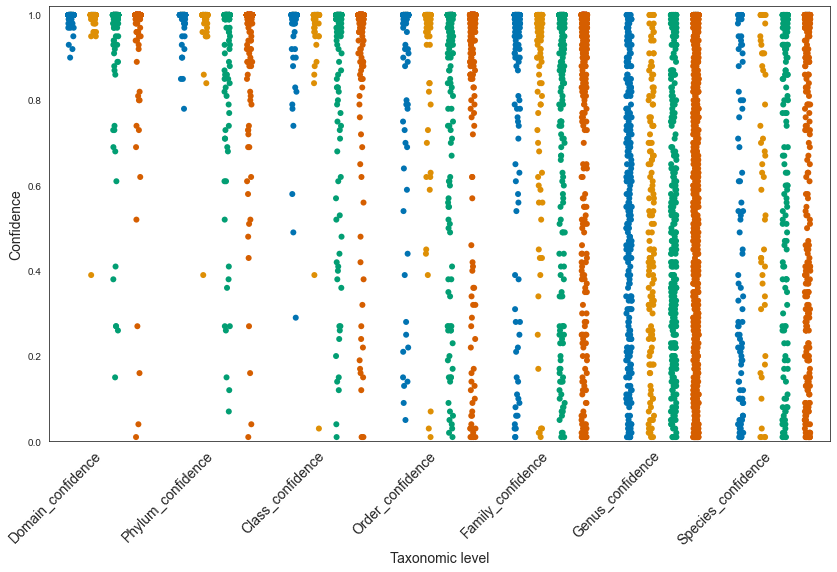

In [17]:
plt.figure(figsize=(14,8))
sns.set_style("white")
#grped_vplot = sns.violinplot(data=df_all_b, x="variable", y="value", hue="Source", 
            # palette="colorblind", scale='width')
scat_plot = sns.stripplot(data=df_all, x="variable", y="value", hue="Source",
                             color="k", dodge=True, palette="colorblind", size=6)
#plt.title("Assembly metrics by program")
plt.ylabel("Confidence", size=14)
plt.xlabel("Taxonomic level", size=14)
plt.xticks(rotation=45, ha='right', size=14)
plt.ylim(0, 1.02)

# Let us first get legend information from the plot object
handles, labels = scat_plot.get_legend_handles_labels()
# specify just one legend
l = plt.legend(handles[0:4], labels[0:4], prop={'size': 15})
plt.gca().get_legend().remove()

plt.savefig("SSU_SILVA_PR2_taxonomy_confidences_scatter_nolegend.svg", format='svg', dpi=1200, bbox_inches='tight')
plt.show()

## Run one-way ANOVA to test for significant differences

In [18]:
import scipy.stats as stats

### Use the original df_all

In [116]:
df_all

,variable,value,Source,Sample
0,Domain_confidence,1.00,SPAdes,1903c122_28
1,Domain_confidence,1.00,SPAdes,1903c122_28
2,Domain_confidence,1.00,SPAdes,1903c122_28
3,Domain_confidence,1.00,SPAdes,1903c122_28
4,Domain_confidence,1.00,SPAdes,1903c122_28
...,...,...,...,...
205,Species_confidence,1.00,Ill-PF,1903c127_7
206,Species_confidence,1.00,Ill-PF,1903c127_7
207,Species_confidence,0.12,Ill-PF,1903c127_7
208,Species_confidence,0.67,Ill-PF,1903c127_7


### Organize dataframe by taxonomy level

In [119]:
df_all_pivot = df_all.pivot_table(columns=['Sample'], index=['variable', 'Source'], values='value')
df_all_pivot

Sample                       1903c111_10  1903c117_50  1903c118_23  \
variable           Source                                            
Class_confidence   Ill-PF       0.982000     0.973590        1.000   
                   SPAdes       0.964412     0.962647          NaN   
                   hybrid       1.000000     0.987273        1.000   
                   metaFlye          NaN     0.999138          NaN   
Domain_confidence  Ill-PF       0.995882     1.000000        1.000   
                   SPAdes       0.990000     0.982941          NaN   
                   hybrid       1.000000     0.997273        1.000   
                   metaFlye          NaN     0.999828          NaN   
Family_confidence  Ill-PF       0.927294     0.901282        0.995   
                   SPAdes       0.862059     0.862353          NaN   
                   hybrid       0.910000     0.901818        0.800   
                   metaFlye          NaN     0.941552          NaN   
Genus_confidence   Ill-PF       0.614824     0.610513        0.570   
                   SPAdes       0.606176     0.552059          NaN   
                   hybrid       0.611000     0.456364        0.380   
                   metaFlye          NaN     0.577241          NaN   
Order_confidence   Ill-PF       0.976941     0.950513        1.000   
                   SPAdes       0.923824     0.919412          NaN   
                   hybrid       0.966000     0.930909        1.000   
                   metaFlye          NaN     0.972241          NaN   
Phylum_confidence  Ill-PF       0.991294     0.996923        1.000   
                   SPAdes       0.970588     0.982647          NaN   
                   hybrid       1.000000     0.996364        1.000   
                   metaFlye          NaN     0.999655          NaN   
Species_confidence Ill-PF       0.717619     0.747368        1.000   
                   SPAdes       0.767059     0.696316          NaN   
                   hybrid       0.650000     0.543333        0.505   
                   metaFlye          NaN     0.603846          NaN   

Sample                       1903c119_11  1903c122_28  1903c123_10  \
variable           Source                                            
Class_confidence   Ill-PF       1.000000     0.985979     0.989888   
                   SPAdes       0.993333     0.906452     0.905143   
                   hybrid       1.000000     0.982727     0.858571   
                   metaFlye     0.983893          NaN          NaN   
Domain_confidence  Ill-PF       1.000000     0.998763     0.996404   
                   SPAdes       1.000000     0.972581     0.968571   
                   hybrid       1.000000     0.998182     0.998571   
                   metaFlye     0.997181          NaN          NaN   
Family_confidence  Ill-PF       0.922857     0.939485     0.918764   
                   SPAdes       0.890000     0.853548     0.775714   
                   hybrid       0.890000     0.914545     0.837143   
                   metaFlye     0.907919          NaN          NaN   
Genus_confidence   Ill-PF       0.607143     0.623299     0.617640   
                   SPAdes       0.684444     0.579677     0.572571   
                   hybrid       0.558000     0.511818     0.512857   
                   metaFlye     0.511611          NaN          NaN   
Order_confidence   Ill-PF       1.000000     0.963299     0.976292   
                   SPAdes       0.905556     0.863548     0.847714   
                   hybrid       0.996000     0.943636     0.858571   
                   metaFlye     0.940470          NaN          NaN   
Phylum_confidence  Ill-PF       1.000000     0.994639     0.996180   
                   SPAdes       1.000000     0.955161     0.934857   
                   hybrid       1.000000     0.996364     0.994286   
                   metaFlye     0.993289          NaN          NaN   
Species_confidence Ill-PF       0.807143     0.794167     0.715909   
         

### Just look at species-level confidences

In [127]:
df_all_pivot.query('variable == "Species_confidence"')

Sample                       1903c111_10  1903c117_50  1903c118_23  \
variable           Source                                            
Species_confidence Ill-PF       0.717619     0.747368        1.000   
                   SPAdes       0.767059     0.696316          NaN   
                   hybrid       0.650000     0.543333        0.505   
                   metaFlye          NaN     0.603846          NaN   

Sample                       1903c119_11  1903c122_28  1903c123_10  \
variable           Source                                            
Species_confidence Ill-PF       0.807143     0.794167     0.715909   
                   SPAdes       0.804000     0.723125     0.653158   
                   hybrid       0.700000     0.626667     0.010000   
                   metaFlye     0.413913          NaN          NaN   

Sample                       1903c124_15  1903c126_45  1903c127_7  \
variable           Source                                           
Species_confidence Ill-PF       0.662222     0.847812    0.682424   
                   SPAdes       0.758333     0.752222    0.659231   
                   hybrid       0.685000          NaN    0.710000   
                   metaFlye          NaN     0.530000         NaN   

Sample                       1903c129_26  1903c144_13  Las19c107_10  \
variable           Source                                             
Species_confidence Ill-PF       0.776304     0.823077      0.711667   
                   SPAdes       0.726190     0.897500      0.758095   
                   hybrid       0.765000     0.486667      0.180000   
                   metaFlye     0.020000          NaN           NaN   

Sample                       Las19c135_5  Las19c138_27  
variable           Source                               
Species_confidence Ill-PF       0.662000      0.733469  
                   SPAdes       0.853125      0.625714  
                   hybrid       0.460000      0.672000  
                   metaFlye          NaN      1.000000

In [130]:
species = df_all_pivot.query('variable == "Species_confidence"')

In [177]:
genus = df_all_pivot.query('variable == "Genus_confidence"')
family = df_all_pivot.query('variable == "Family_confidence"')
order = df_all_pivot.query('variable == "Order_confidence"')
Class = df_all_pivot.query('variable == "Class_confidence"')
phylum = df_all_pivot.query('variable == "Phylum_confidence"')
domain = df_all_pivot.query('variable == "Domain_confidence"')

### Make arrays of each group and remove NaN values

In [218]:
meta = domain.query('Source == "metaFlye"').to_numpy()
meta = meta[~np.isnan(meta)]

In [219]:
illpf = domain.query('Source == "Ill-PF"').to_numpy()
illpf = illpf[~np.isnan(illpf)]

In [220]:
hybrid = domain.query('Source == "hybrid"').to_numpy()
hybrid = hybrid[~np.isnan(hybrid)]

In [221]:
spad = domain.query('Source == "SPAdes"').to_numpy()
spad = spad[~np.isnan(spad)]

## Run ANOVA to test for differences

In [222]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(meta, 
                                illpf, 
                                hybrid, 
                                spad)
print(fvalue, pvalue)

5.2070736274571985 0.0037866938712315347


#### We know that group values are statistically significantly different, but ANOVA does not tell which groups are significantly different from which other groups. To know the pairs of significant different treatments, we will perform multiple pairwise comparison (post hoc comparison) analysis for all unplanned comparison using Tukey’s honestly significantly differenced (HSD) test.

In [159]:
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test

/Users/nastassia.patin/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/nastassia.patin/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


### Use df_all_b

In [163]:
df_all_b

,Source,variable,value,Sample
0,metaFlye,Domain_confidence,0.98,1903c119_11
1,metaFlye,Domain_confidence,1.00,1903c119_11
2,metaFlye,Domain_confidence,1.00,1903c119_11
3,metaFlye,Domain_confidence,1.00,1903c119_11
4,metaFlye,Domain_confidence,1.00,1903c119_11
...,...,...,...,...
12054,Ill-PF,Species_confidence,1.00,1903c127_7
12055,Ill-PF,Species_confidence,1.00,1903c127_7
12056,Ill-PF,Species_confidence,0.12,1903c127_7
12057,Ill-PF,Species_confidence,0.67,1903c127_7


In [223]:
df_all_tukey = df_all_b.loc[df_all_b['variable'] == 'Domain_confidence']
df_all_tukey = df_all_tukey.loc[~df_all_tukey['value'].isna()]
df_all_tukey['variable_full'] = df_all_tukey['Source'] + "_" + df_all_tukey['variable']
df_all_tukey = df_all_tukey.drop(columns=['Source', 'variable','Sample'])
df_all_tukey

,value,variable_full
0,0.98,metaFlye_Domain_confidence
1,1.00,metaFlye_Domain_confidence
2,1.00,metaFlye_Domain_confidence
3,1.00,metaFlye_Domain_confidence
4,1.00,metaFlye_Domain_confidence
...,...,...
11874,1.00,Ill-PF_Domain_confidence
11875,1.00,Ill-PF_Domain_confidence
11876,1.00,Ill-PF_Domain_confidence
11877,1.00,Ill-PF_Domain_confidence


In [224]:
res = stat()
res.tukey_hsd(df=df_all_tukey, res_var='value', xfac_var='variable_full', anova_model='value ~ C(variable_full)')
res.tukey_summary

/Users/nastassia.patin/miniconda3/lib/python3.8/site-packages/bioinfokit/analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,metaFlye_Domain_confidence,hybrid_Domain_confidence,0.004505,-0.013095,0.022106,0.930959,0.900000
1,metaFlye_Domain_confidence,SPAdes_Domain_confidence,0.017976,0.004365,0.031587,4.803093,0.003897
2,metaFlye_Domain_confidence,Ill-PF_Domain_confidence,0.005841,-0.005960,0.017643,1.800083,0.570816
3,hybrid_Domain_confidence,SPAdes_Domain_confidence,0.013470,-0.003375,0.030316,2.908025,0.168244
4,hybrid_Domain_confidence,Ill-PF_Domain_confidence,0.001336,-0.014085,0.016757,0.315029,0.900000
5,SPAdes_Domain_confidence,Ill-PF_Domain_confidence,0.012135,0.001491,0.022778,4.146296,0.017938


#### Note: p-value 0.001 from tukey_hsd output should be interpreted as <=0.001

In [184]:
os.chdir("/Users/nastassia.patin/Desktop/Projects/Lasker2019/Long read paper/mSystems/Revisions/new-vsearch")

In [226]:
res.tukey_summary.to_csv("Domain_differences_HSD_SILVA_PR2.csv", index=None)